In [7]:
import os, sys

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
import random 
from tqdm import tqdm 
import numpy as np 
from visual import find_opt_thres, get_metric_invariant


MRR: 0.50


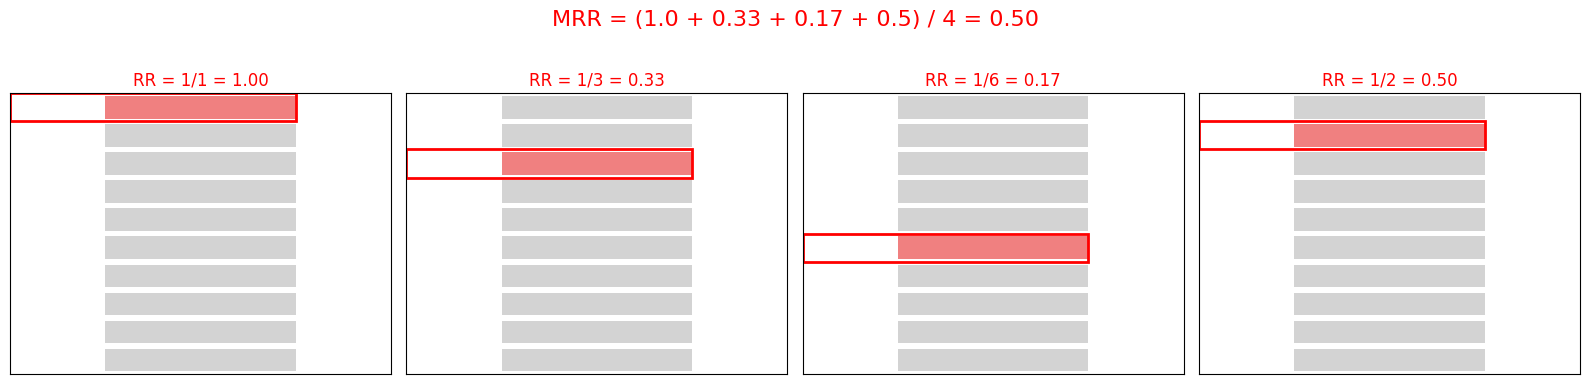

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Example relevance data for 4 queries
relevance_data = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RR = 1/1 = 1
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # RR = 1/3 = 0.33
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # RR = 1/6 = 0.17
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # RR = 1/2 = 0.5
]

# Calculate RR and MRR
reciprocal_ranks = []
for relevance in relevance_data:
    try:
        first_relevant_index = relevance.index(1)
        rr = 1 / (first_relevant_index + 1)
    except ValueError:
        rr = 0
    reciprocal_ranks.append(rr)

mrr = np.mean(reciprocal_ranks)
print(f"MRR: {mrr:.2f}")

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (ax, relevance, rr) in enumerate(zip(axes, relevance_data, reciprocal_ranks)):
    colors = ['lightcoral' if x == 1 else 'lightgrey' for x in relevance]
    ax.barh(range(1, 11), [1] * 10, color=colors, edgecolor='none')
    first_relevant_index = relevance.index(1)
    ax.add_patch(plt.Rectangle((-0.5, first_relevant_index + 0.5), 1.5, 1, fill=None, edgecolor='red', lw=2))
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(10.5, 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'RR = 1/{first_relevant_index + 1} = {rr:.2f}', fontsize=12, color='red')

fig.suptitle(f'MRR = ({ " + ".join([str(round(rr, 2)) for rr in reciprocal_ranks]) }) / 4 = {mrr:.2f}', fontsize=16, color='red')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Test 1: Neg and Pos follow the gaussian distribution with different mean and variance

\begin{equation}
P1 \sim \mathcal{N}(\mu_{\text{pos}}, \sigma_{\text{pos}}^2) \quad P2 \sim \mathcal{N}(\mu_{\text{neg}}, \sigma_{\text{neg}}^2) 
\end{equation}

\begin{equation}
P(x | H_1) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp( -\frac{(x - 1)^2}{2\sigma^2} ) 
\end{equation}

\begin{equation}
P(x | H_0) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp( -\frac{(x + 1)^2}{2\sigma^2})
\end{equation}

\begin{equation}
P(H_1 | x) = \frac{P(x | H_1) P(H_1)}{P(x)}, \text{prior}: P(H_1), \quad \text{data dist}: P(x), \quad \text{likelihood}: P(x | H_1) P(H_1)
\end{equation}

$$
\text{Decision based on MAP} = \begin{cases}
H_0 & \text{if } P(H_0 \mid x) > P(H_1 \mid x) \\
H_1 & \text{if } P(H_1 \mid x) > P(H_0 \mid x)
\end{cases}
$$


| ![Image 1](map_binary.png) | ![Image 2](plot_unequal_priors_intersection.png) |
| --------------------- | --------------------- |
| Two Ns with the same prior| Two Ns with different priors  |

\begin{equation}
\text{Optimal threshold minimized Jorden Statistic} \quad x \gtrless \frac{\sigma^2}{2} \ln \left( \frac{P(H_0)}{P(H_1)} \right) + \frac{1}{2} 
\end{equation}

20it [00:00, 27.83it/s]
20it [00:00, 27.47it/s]


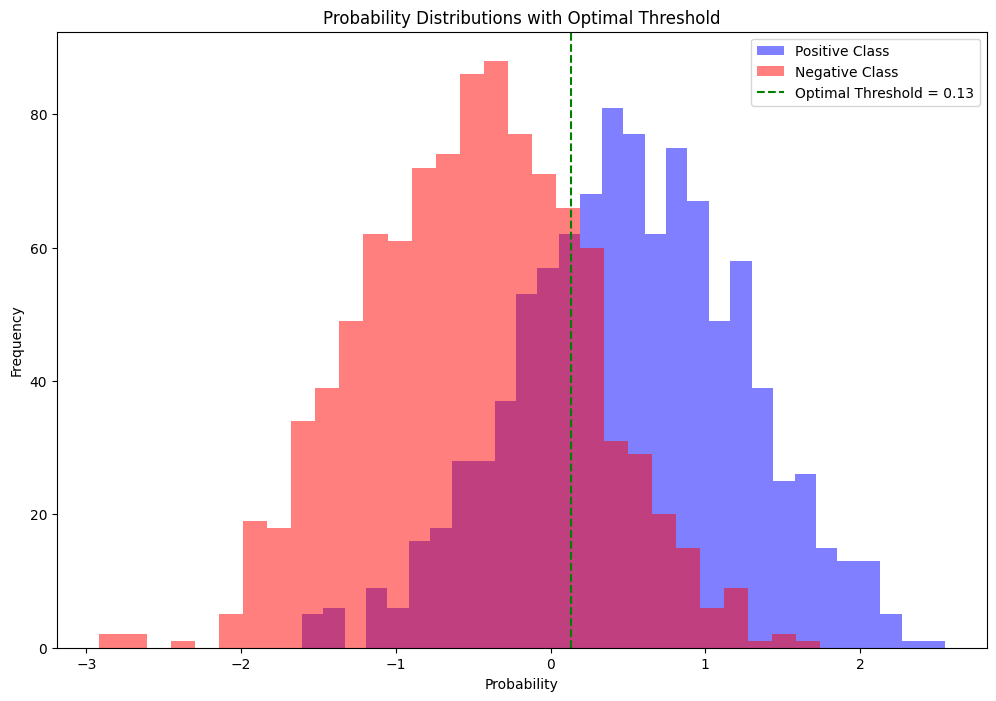

<Figure size 640x480 with 0 Axes>

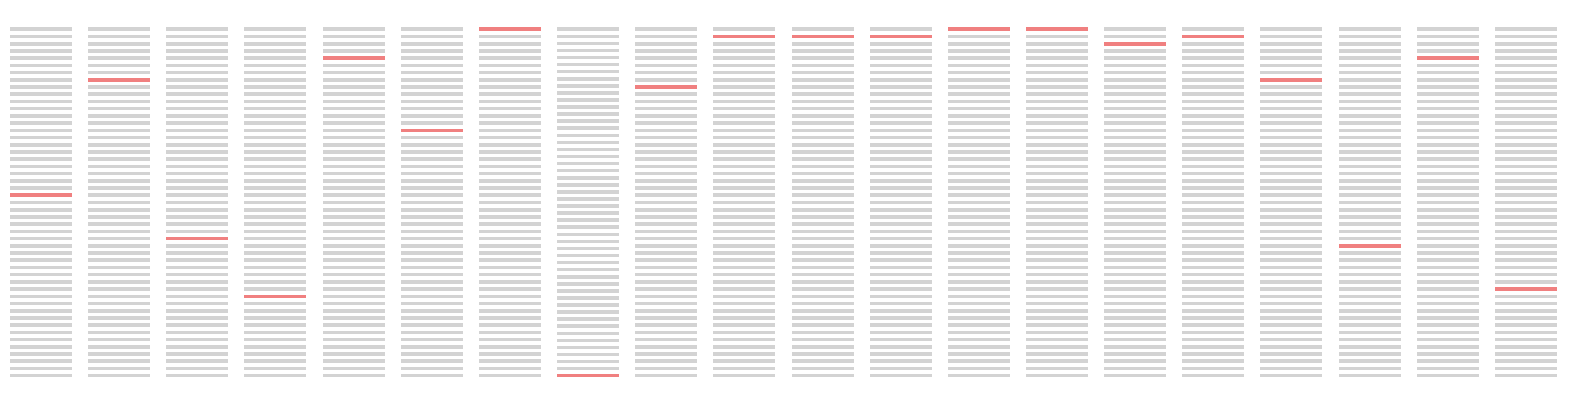

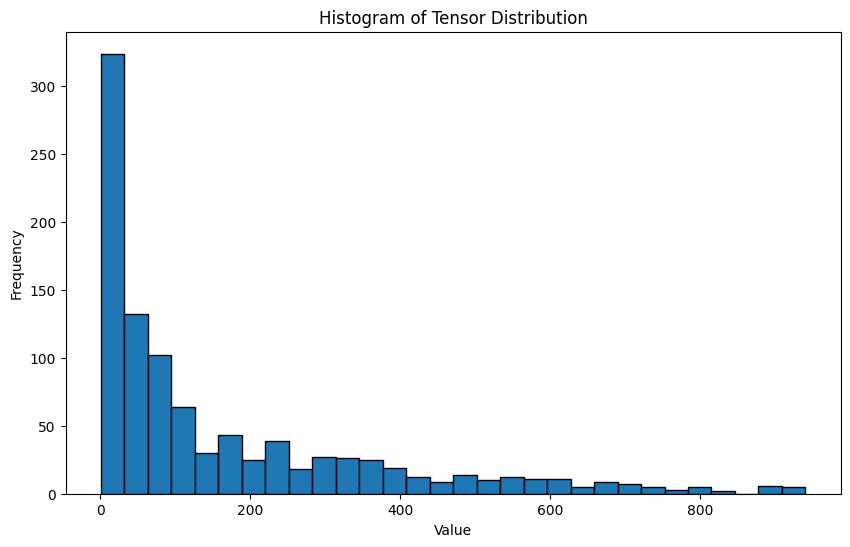

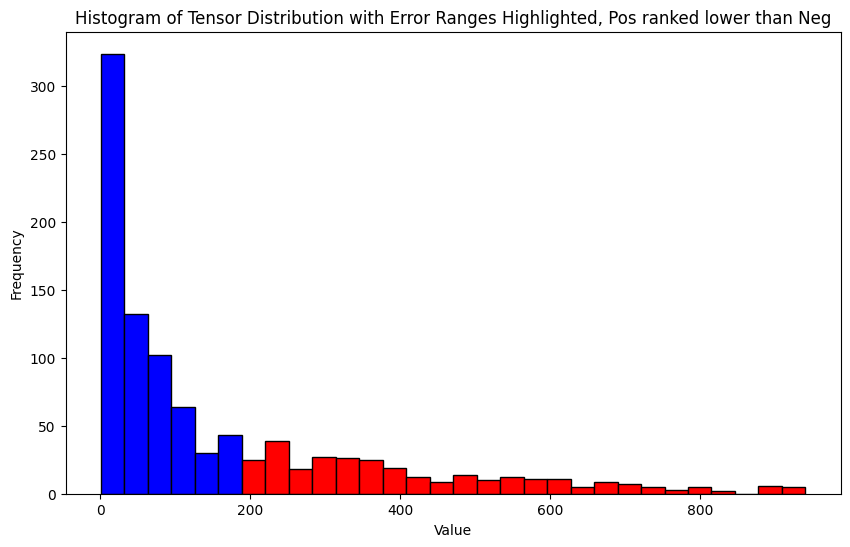

<Figure size 640x480 with 0 Axes>

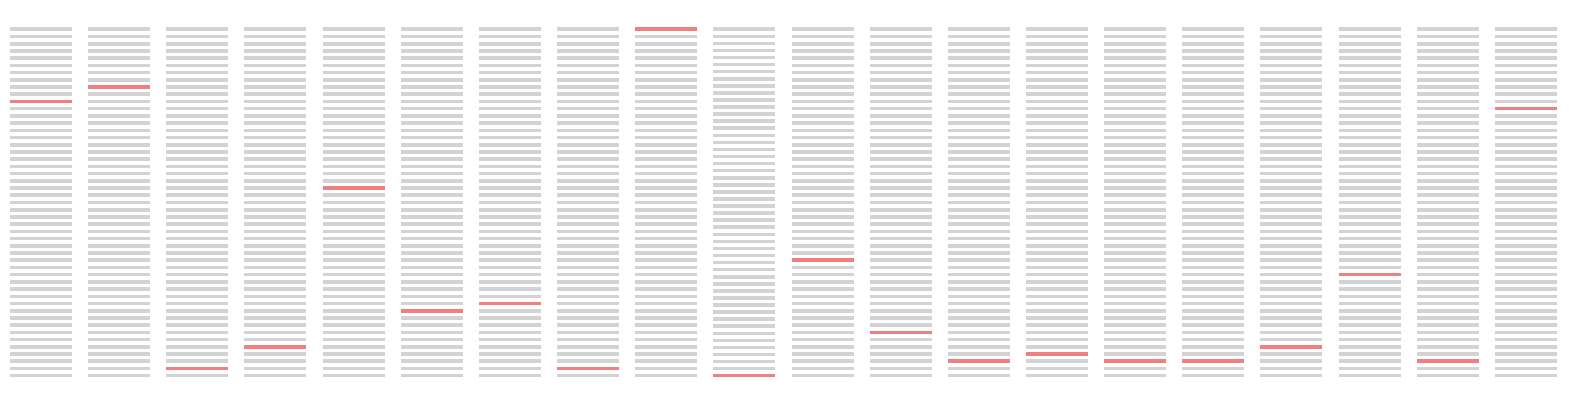

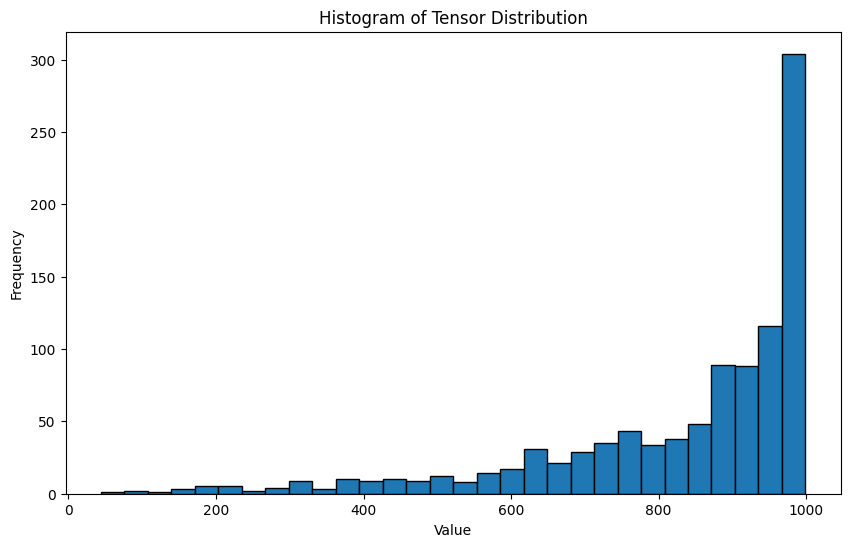

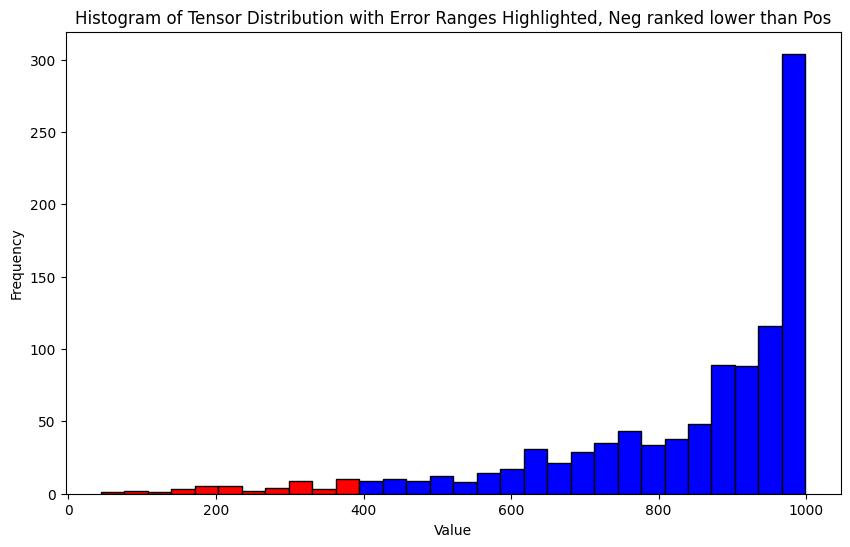

In [10]:
# evaluator = Evaluator(name='ogbl-collab')
evaluator_hit = Evaluator(name='ogbl-collab')
evaluator_mrr = Evaluator(name='ogbl-citation2')

mean_pos, var_pos = 0.5, 0.5  # Mean and variance for positive class 
mean_neg, var_neg = -0.5, 0.5  # Mean and variance for negative class
size = 1000  # Number of samples in each class

P1 = np.random.normal(loc=mean_pos, scale=np.sqrt(var_pos), size=size)
P2 = np.random.normal(loc=mean_neg, scale=np.sqrt(var_neg), size=size)
pos_index = np.random.randint(low=0, high=size-1, size=(size, 2)) 
neg_index = np.random.randint(low=0, high=size-1, size=(size, 2)) 

plt.figure(figsize=(12, 8))

# Plot distributions of probabilities
plt.hist(P1, bins=30, alpha=0.5, color='blue', label='Positive Class')
plt.hist(P2, bins=30, alpha=0.5, color='red', label='Negative Class')
best_thres, best_acc, pos_pred, neg_pred = find_opt_thres(P1, P2)

plt.axvline(best_thres, color='green', linestyle='--', label=f'Optimal Threshold = {best_thres:.2f}')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Probability Distributions with Optimal Threshold')
plt.savefig('optimal_threshold.png')
P1 = torch.tensor(P1)
P2 = torch.tensor(P2)
# result = get_metric_score(evaluator_hit, evaluator_mrr, P1, P2)


k_list  = [0.1, 0.2, 0.3, 0.5, 1]
mrr_pos2neg, mrr_neg2pos, result_auc_test, pos_edge_index_err, pos_rank_err, neg_edge_index_err, neg_rank_err = get_metric_invariant(P1, pos_index, P2, neg_index, k_list)

In [11]:
mrr_pos2neg, mrr_neg2pos

({'mrr_hit0.1': tensor(0.5730),
  'mrr_hit0.2': tensor(0.7130),
  'mrr_hit0.3': tensor(0.7960),
  'mrr_hit0.5': tensor(0.9080),
  'mrr_hit1.0': tensor(1.)},
 {'mrr_hit0.1': tensor(0.0030),
  'mrr_hit0.2': tensor(0.0110),
  'mrr_hit0.3': tensor(0.0230),
  'mrr_hit0.5': tensor(0.0790),
  'mrr_hit1.0': tensor(1.)})

In [12]:
result_auc_test

{'AUC': 0.8363, 'AP': 0.84}

In [13]:
pos_edge_index_err

array([[684, 531],
       [355, 869],
       [312, 232],
       [877, 125],
       [531, 511],
       [324, 236],
       [925, 955],
       [496, 165],
       [874, 372],
       [248, 337],
       [775, 766],
       [205,  20],
       [407, 428],
       [796, 884],
       [471, 952],
       [985, 380],
       [229, 164],
       [744, 994],
       [601, 103],
       [967, 246],
       [575, 569],
       [ 35, 343],
       [783, 324],
       [ 73, 825],
       [503, 557],
       [734, 858],
       [951, 502],
       [558, 290],
       [339, 480],
       [215, 878],
       [760, 698],
       [572, 867],
       [590, 211],
       [617,  19],
       [ 15, 839],
       [913, 772],
       [326, 749],
       [230, 629],
       [826, 776],
       [941, 672],
       [719, 469],
       [663, 388],
       [882, 581],
       [970, 606],
       [618,  76],
       [801, 410],
       [996, 120],
       [739, 979],
       [533, 302],
       [767, 770],
       [750, 126],
       [868, 956],
       [217,

In [14]:
pos_rank_err

array([659, 342, 194, 556, 231, 310, 244, 400, 231, 811, 359, 318, 884,
       193, 563, 358, 252, 326, 697, 353, 318, 318, 419, 465, 332, 479,
       249, 289, 229, 916, 548, 709, 810, 215, 275, 290, 364, 229, 242,
       286, 559, 338, 287, 920, 477, 667, 382, 755, 582, 194, 376, 224,
       351, 483, 194, 194, 241, 470, 249, 433, 601, 667, 564, 792, 313,
       193, 509, 356, 347, 224, 578, 193, 281, 246, 288, 289, 305, 771,
       482, 892, 402, 550, 432, 429, 487, 210, 266, 402, 709, 192, 583,
       435, 265, 439, 287, 228, 358, 195, 575, 284, 408, 345, 223, 433,
       318, 447, 257, 328, 617, 589, 615, 267, 444, 402, 632, 209, 252,
       923, 343, 521, 356, 810, 326, 531, 288, 531, 741, 286, 581, 206,
       750, 243, 354, 343, 726, 251, 697, 625, 603, 313, 228, 366, 333,
       637, 263, 494, 367, 507, 906, 291, 659, 332, 452, 662, 522, 286,
       198, 632, 373, 324, 209, 681, 406, 299, 908, 273, 618, 194, 333,
       318, 284, 625, 822, 258, 244, 269, 560, 559, 881, 668, 40

In [15]:
neg_edge_index_err

array([[189, 407],
       [166, 520],
       [903, 241],
       [548, 561],
       [767, 348],
       [439, 881],
       [657, 367],
       [873, 313],
       [888, 169],
       [325, 960],
       [318, 707],
       [960, 190],
       [ 17, 598],
       [266, 208],
       [261, 889],
       [916, 623],
       [121,   5],
       [266, 627],
       [  9, 177],
       [801, 232],
       [287, 524],
       [644,  26],
       [136, 323],
       [164, 397],
       [849, 244],
       [119, 746],
       [194, 478],
       [668, 894],
       [870, 904],
       [906, 241],
       [ 19, 919],
       [372, 344],
       [420, 283],
       [790, 374],
       [908,  56],
       [859, 738],
       [569, 441],
       [216, 477],
       [316, 176],
       [697, 132],
       [399, 893],
       [331, 166],
       [317, 804],
       [550,  84],
       [656, 510]])

In [16]:
neg_rank_err 

array([207, 348, 312, 231, 348, 392, 362, 376, 175, 291, 307, 372,  93,
       158,  44, 393, 302, 195, 391, 379, 136, 219, 148, 187, 206, 203,
       323, 290, 311, 390, 374, 306, 306, 311, 262, 195, 370,  80, 372,
       231, 156, 290, 297, 244, 322])